## Import Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

## Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    raw_data = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    raw_data = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)
raw_data.tail(10)
ticker_data = raw_data[["Open", "Close", "Low", "High", "Volume"]]
ticker_data.columns = ["open", "close", "low", "high", "volume"]
ticker_data

,open,close,low,high,volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.1,942.9,943.6,1812
2018-08-13 09:05:00,943.1,943.3,942.9,943.5,1323
2018-08-13 09:10:00,943.2,943.1,942.6,943.3,1207
2018-08-13 09:15:00,943.1,942.6,942.3,943.1,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2024-07-19 14:15:00,1301.2,1299.5,1298.3,1301.6,9058
2024-07-19 14:20:00,1299.1,1301.6,1295.3,1301.8,12762
2024-07-19 14:25:00,1302.4,1302.2,1300.1,1302.6,8096


In [3]:
#@title Raw Price
def cal_first_close(tick):
  if not tick.empty:
    return tick[0]


def cal_high(tick):
  tick = tick[100*tick.index.hour+tick.index.minute > 925]
  tick = tick[100*tick.index.hour+tick.index.minute < 1355]
  return tick.max()


def cal_low(tick):
  tick = tick[100*tick.index.hour+tick.index.minute > 925]
  tick = tick[100*tick.index.hour+tick.index.minute < 1355]
  return tick.min()


def cal_price(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1355]
  if not tick.empty:
    return tick[0]

def cal_close(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1425]
  if not tick.empty:
    return tick[0]

In [ ]:
price = ticker_data
price['first_close'] = price.close
price['price'] = price.close
price = price.resample("D").agg({
    'first_close': cal_first_close,
    'high':cal_high,
    'low': cal_low,
    'price': cal_price,
    'close': cal_close
    })
raw = price.dropna()

In [4]:
price = raw.copy()
price['percent'] = 100 * (price.price - price.close.shift(1)) / price.close.shift(1)
price['returns'] = (price.price - price.first_close) / (price.high - price.low)
price['return'] = 1000 * (price.close - price.price) / price.price
price.tail(10)

,first_close,high,low,price,close,percent,returns,return
Date,,,,,,,,
2024-07-08,1316.1,1316.5,1305.6,1310.7,1312.0,-0.417870,-0.495413,0.991836
2024-07-09,1315.1,1320.3,1304.5,1318.2,1319.5,0.472561,0.196203,0.986193
2024-07-10,1319.6,1321.9,1313.6,1316.3,1310.3,-0.242516,-0.397590,-4.558231
2024-07-11,1314.9,1317.9,1310.2,1312.2,1306.6,0.145005,-0.350649,-4.267642
2024-07-12,1304.6,1310.0,1300.8,1302.8,1299.5,-0.290831,-0.195652,-2.533006
2024-07-15,1302.9,1305.6,1298.7,1299.9,1297.0,0.030781,-0.434783,-2.230941
2024-07-16,1301.6,1308.7,1301.1,1303.1,1301.8,0.470316,0.197368,-0.997621
2024-07-17,1308.2,1315.5,1301.7,1314.0,1296.9,0.937164,0.420290,-13.013699
2024-07-18,1303.9,1304.0,1291.6,1291.6,1297.7,-0.408667,-0.991935,4.722824


### return distributions

In [5]:
price['return'].describe()

count    1479.000000
mean       -0.162522
std         5.901752
min       -27.832377
25%        -2.706681
50%         0.169062
75%         2.844748
max        29.089314
Name: return, dtype: float64

In [6]:
price['return_group'] = pd.cut(price['return'], 30)
s1 = price.groupby(['return_group'])[['return']].count()
f1 = s1[['return']].rename(columns={'return': 'count'})
price.drop(columns=['return_group'], inplace=True)
f1

,count
return_group,
"(-27.889, -25.935]",1
"(-25.935, -24.038]",2
"(-24.038, -22.14]",0
"(-22.14, -20.243]",6
"(-20.243, -18.345]",5
"(-18.345, -16.448]",7
"(-16.448, -14.551]",14
"(-14.551, -12.653]",14
"(-12.653, -10.756]",17


In [7]:
price = price[price['return'] > -16.5]
price = price[price['return'] <  12.1]

### percent distributions

In [8]:
price['percent'].describe()

count    1430.000000
mean        0.054555
std         1.221765
min        -7.200119
25%        -0.394293
50%         0.099679
75%         0.622001
max         7.145188
Name: percent, dtype: float64

In [9]:
price['returns'].describe()

count    1431.000000
mean        0.021358
std         0.630271
min        -2.005435
25%        -0.482759
50%         0.041667
75%         0.513514
max         1.636364
Name: returns, dtype: float64

In [10]:
price['percent_group'] = pd.qcut(price.percent, 30)
price['returns_group'] = pd.qcut(price.returns, 36)

## Analysis

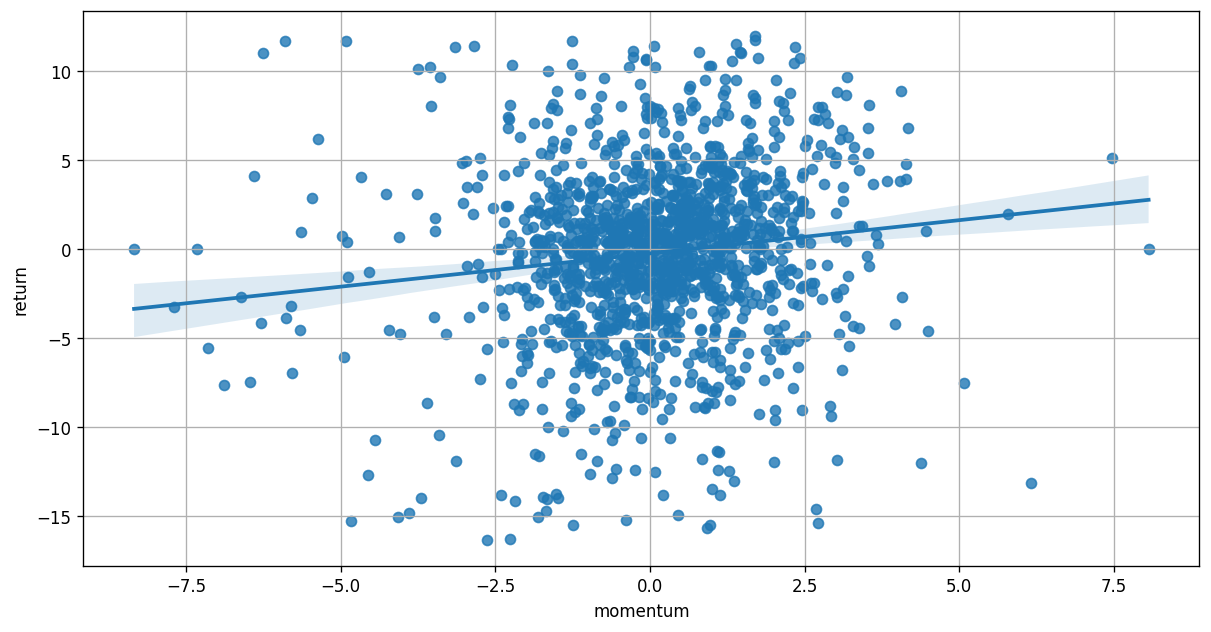

In [11]:
price['momentum'] = price.percent + price.returns
sns.regplot(x=price['momentum'], y=price['return'])
plt.grid(True)

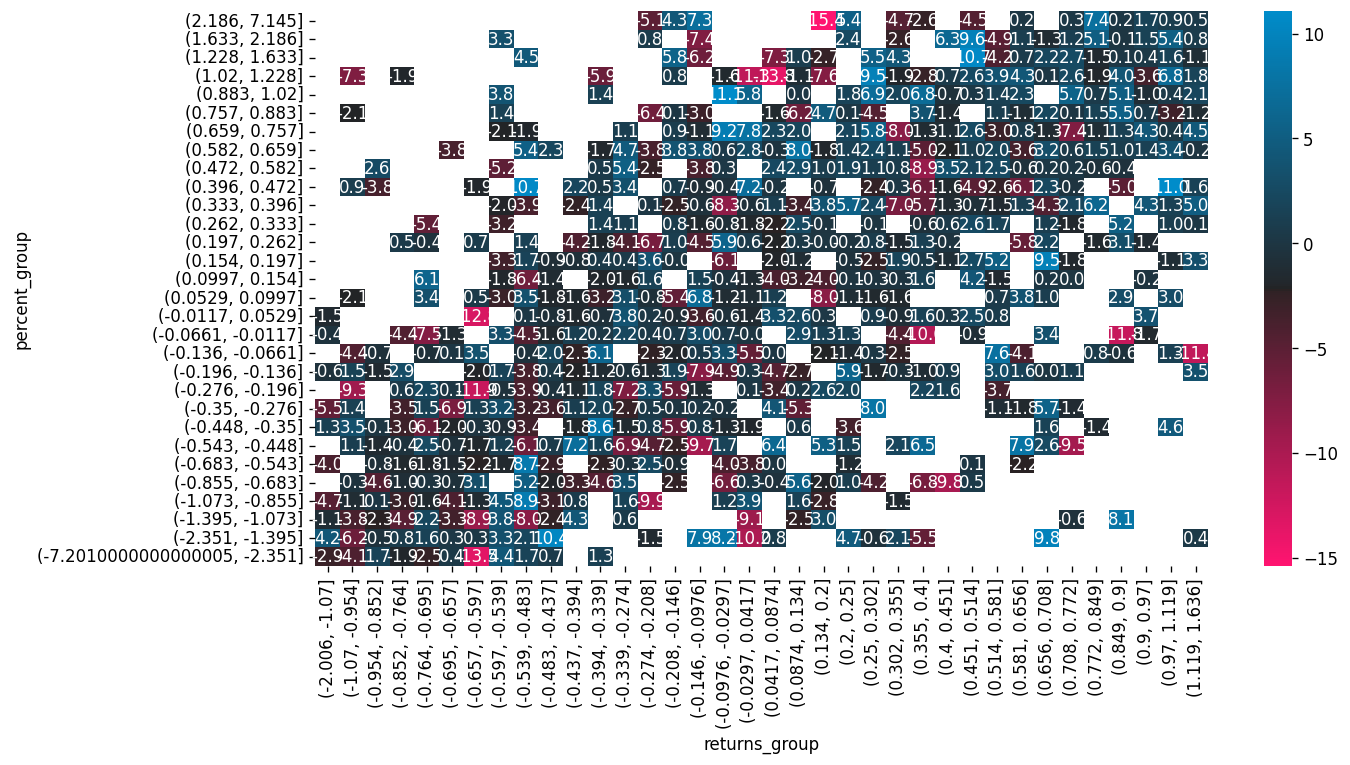

In [12]:
grpd = price.groupby(['percent_group', 'returns_group'])[['return']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='percent_group', columns='returns_group', values='return').sort_index(ascending=False),
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f");

## Long

In [13]:
Long = price[price.percent > .26]
Long = Long[Long.returns > .39]
Long

,first_close,high,low,price,close,percent,returns,return,percent_group,returns_group,momentum
Date,,,,,,,,,,,
2018-08-14,954.9,958.6,952.1,959.5,960.1,0.565978,0.707692,0.625326,"(0.472, 0.582]","(0.708, 0.772]",1.273671
2018-08-21,944.5,950.8,944.5,950.1,954.7,0.571610,0.888889,4.841596,"(0.472, 0.582]","(0.849, 0.9]",1.460499
2018-08-23,957.0,959.9,955.8,962.6,961.0,0.785258,1.365854,-1.662165,"(0.757, 0.883]","(1.119, 1.636]",2.151112
2018-08-27,961.5,965.2,961.5,963.7,963.0,0.500574,0.594595,-0.726367,"(0.472, 0.582]","(0.581, 0.656]",1.095168
2018-09-07,934.6,942.6,930.5,941.3,944.8,0.630746,0.553719,3.718262,"(0.582, 0.659]","(0.514, 0.581]",1.184465
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-12,1303.1,1312.9,1302.5,1313.9,1328.4,0.435713,1.038462,11.035847,"(0.396, 0.472]","(0.97, 1.119]",1.474175
2024-06-18,1311.9,1319.7,1311.4,1321.4,1309.5,0.877930,1.144578,-9.005600,"(0.757, 0.883]","(1.119, 1.636]",2.022508
2024-07-02,1286.6,1299.0,1284.6,1297.1,1296.6,0.957347,0.729167,-0.385475,"(0.883, 1.02]","(0.708, 0.772]",1.686514


In [14]:
Long['tail'] = (Long.high - Long.price) / (Long.high - Long.first_close)
Long['tail_group'] = pd.qcut(Long['tail'], 15, duplicates='drop')
Long[['return', 'tail_group']].groupby(['tail_group']).mean()
Long

,first_close,high,low,price,close,percent,returns,return,percent_group,returns_group,momentum,tail,tail_group
Date,,,,,,,,,,,,,
2018-08-14,954.9,958.6,952.1,959.5,960.1,0.565978,0.707692,0.625326,"(0.472, 0.582]","(0.708, 0.772]",1.273671,-0.243243,"(-2.401, -0.16]"
2018-08-21,944.5,950.8,944.5,950.1,954.7,0.571610,0.888889,4.841596,"(0.472, 0.582]","(0.849, 0.9]",1.460499,0.111111,"(0.0791, 0.111]"
2018-08-23,957.0,959.9,955.8,962.6,961.0,0.785258,1.365854,-1.662165,"(0.757, 0.883]","(1.119, 1.636]",2.151112,-0.931034,"(-2.401, -0.16]"
2018-08-27,961.5,965.2,961.5,963.7,963.0,0.500574,0.594595,-0.726367,"(0.472, 0.582]","(0.581, 0.656]",1.095168,0.405405,"(0.405, 0.5]"
2018-09-07,934.6,942.6,930.5,941.3,944.8,0.630746,0.553719,3.718262,"(0.582, 0.659]","(0.514, 0.581]",1.184465,0.162500,"(0.162, 0.192]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-12,1303.1,1312.9,1302.5,1313.9,1328.4,0.435713,1.038462,11.035847,"(0.396, 0.472]","(0.97, 1.119]",1.474175,-0.102041,"(-0.16, -0.0625]"
2024-06-18,1311.9,1319.7,1311.4,1321.4,1309.5,0.877930,1.144578,-9.005600,"(0.757, 0.883]","(1.119, 1.636]",2.022508,-0.217949,"(-2.401, -0.16]"
2024-07-02,1286.6,1299.0,1284.6,1297.1,1296.6,0.957347,0.729167,-0.385475,"(0.883, 1.02]","(0.708, 0.772]",1.686514,0.153226,"(0.139, 0.162]"


In [15]:
Long['return'].sum()

294.48791072380317

In [16]:
this_month = Long[(Long.index > '2024-06-01 00:00:00') & (Long.index < '2024-06-30 15:00:00')]
this_month['return'].sum()

-0.20637149340488925

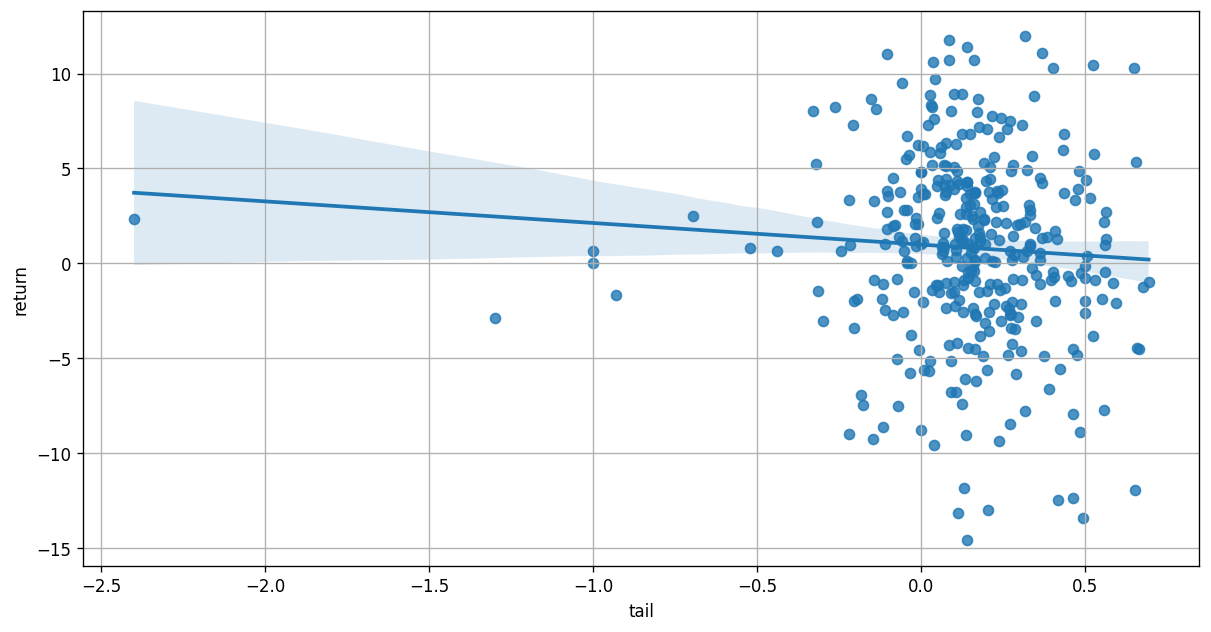

In [17]:
sns.regplot(x=Long['tail'], y=Long['return'])
plt.grid(True)

## Short

In [18]:
Short = price[price.percent < -.18]
Short = Short[Short.returns < -.39]

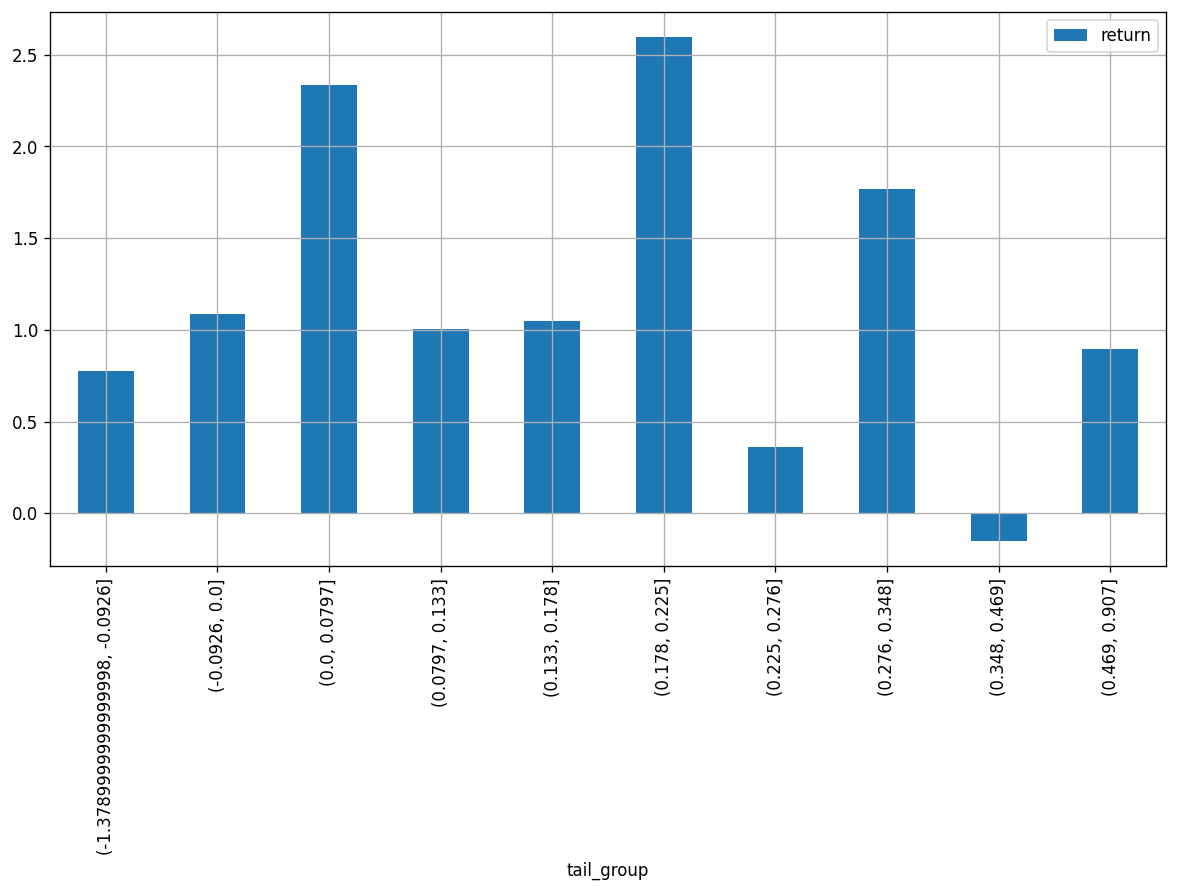

In [19]:
Short['tail'] = (Short.price - Short.low) / (Short.high - Short.low)
Short['tail_group'] = pd.qcut(Short['tail'], 10)
(-Short[['return', 'tail_group']].groupby(['tail_group']).mean()).plot.bar()
plt.grid(True)

In [20]:
Short

,first_close,high,low,price,close,percent,returns,return,percent_group,returns_group,momentum,tail,tail_group
Date,,,,,,,,,,,,,
2018-08-29,965.7,965.9,963.2,962.3,963.9,-0.372709,-1.259259,1.662683,"(-0.448, -0.35]","(-2.006, -1.07]",-1.631969,-0.333333,"(-1.3789999999999998, -0.0926]"
2018-09-05,952.7,954.4,945.6,947.4,942.5,-1.003135,-0.602273,-5.172050,"(-1.073, -0.855]","(-0.657, -0.597]",-1.605408,0.204545,"(0.178, 0.225]"
2018-09-06,945.0,945.8,936.6,935.6,935.4,-0.732095,-1.021739,-0.213767,"(-0.855, -0.683]","(-1.07, -0.954]",-1.753835,-0.108696,"(-1.3789999999999998, -0.0926]"
2018-09-10,943.5,944.8,936.3,936.1,938.0,-0.920830,-0.870588,2.029698,"(-1.073, -0.855]","(-0.954, -0.852]",-1.791418,-0.023529,"(-0.0926, 0.0]"
2018-10-05,990.4,990.8,985.3,987.1,982.7,-0.182020,-0.600000,-4.457502,"(-0.196, -0.136]","(-0.657, -0.597]",-0.782020,0.327273,"(0.276, 0.348]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,1314.9,1317.3,1290.4,1296.8,1287.1,-1.571157,-0.672862,-7.479951,"(-2.351, -1.395]","(-0.695, -0.657]",-2.244020,0.237918,"(0.225, 0.276]"
2024-06-28,1292.0,1291.2,1281.2,1283.9,1277.9,-0.457435,-0.810000,-4.673261,"(-0.543, -0.448]","(-0.852, -0.764]",-1.267435,0.270000,"(0.225, 0.276]"
2024-07-08,1316.1,1316.5,1305.6,1310.7,1312.0,-0.417870,-0.495413,0.991836,"(-0.448, -0.35]","(-0.539, -0.483]",-0.913282,0.467890,"(0.348, 0.469]"


In [21]:
abs(Short['return'].sum())

380.0390585271187

In [22]:
short_this_month = Short[(Short.index > '2024-06-01 00:00:00') & (Short.index < '2024-06-30 15:00:00')]
short_this_month['return'].sum()

-9.346949324318242

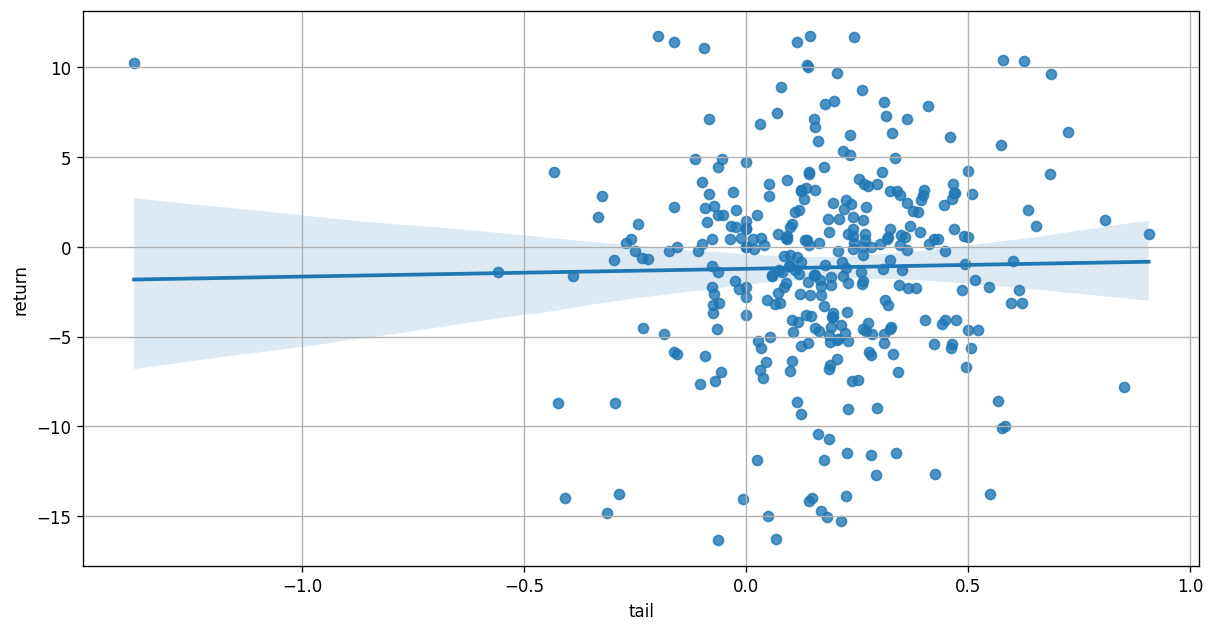

In [23]:
sns.regplot(x=Short['tail'], y=Short['return'])
plt.grid(True)